In [1]:
import numpy as np   # linear algebra
import pandas as pd   # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
## unzip files
# import glob
# import zipfile

In [3]:
# files = glob.glob('model_input/cassava-leaf-disease-classification/cassava-leaf-disease-classification.zip')
# print(files)

In [4]:
# for file in files:
#     print('Unzipping:',file)
#     print(file)
#     with zipfile.ZipFile(file, 'r') as zip_ref:
#         zip_ref.extractall('model_input/cassava-leaf-disease-classification')

In [5]:
!pip install timm
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import timm
import cv2
import torch.optim as optim
import torchvision.models as models
import torchvision

from PIL import Image
from tqdm.notebook import tqdm
from sklearn import model_selection, metrics
from torch.utils.data import DataLoader
from tqdm import tqdm
from transformers import ViTModel
from torch.optim.lr_scheduler import StepLR

from transformers import ViTForImageClassification,ViTConfig,AutoModel

from statistics import mean

plt.style.use('fivethirtyeight')

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
use_cuda, device

(True, device(type='cuda'))

In [4]:
BASE_PATH = 'model_input/cassava-leaf-disease-classification'

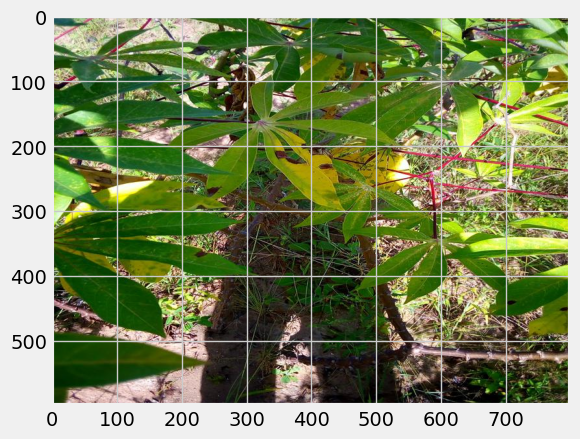

(600, 800, 3)

In [5]:
image = cv2.imread(BASE_PATH+'/train_images/1000015157.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()
image.shape

In [85]:
IMG_SIZE = 224
BATCH_SIZE = 16
LR = 1e-4
EPOCHS = 10
num_classes = 5

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
learn_rates=[1e-5,1e-4,1e-3]
model_name="google/vit-base-patch16-224"
saving_dir="hyperparameters_save_pretrained"

In [63]:
train = pd.read_csv(BASE_PATH+'/train.csv')
train.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [64]:
# train = train[:100]

In [65]:
train.shape

(21397, 2)

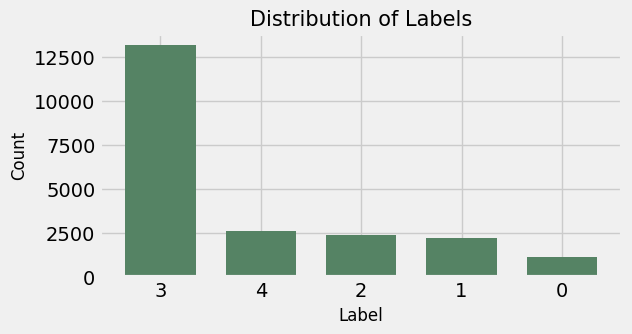

In [66]:
plt.figure(figsize=(6, 3))

train['label'].value_counts().plot(
    kind='bar',
    color='#558364',
    width=0.7
)

plt.xlabel('Label', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Distribution of Labels', fontsize=15)
plt.xticks(rotation=360)
plt.show()

In [67]:
train_df, val_df = model_selection.train_test_split(
    train, test_size=0.12, random_state=42, stratify=train['label'].values
)

In [68]:
class LeafDataset(torch.utils.data.Dataset):
    
    def __init__(self, df, data_path=BASE_PATH, mode='train', transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms 
        self.mode = mode
        self.data_dir = 'train_images' if mode == 'train' else 'test_images'
    
    def __len__(self):
        return len(self.df_data)
    
    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        
        if self.transforms is not None:
            img = self.transforms(img)
            
        return img, label

In [69]:
transforms_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(p=0.2),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomResizedCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transforms_val = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

In [70]:
train_dataset = LeafDataset(df=train_df, data_path=BASE_PATH, mode='train', transforms=transforms_train)
val_dataset = LeafDataset(df=val_df, data_path=BASE_PATH, mode='train', transforms=transforms_val)

In [71]:
len(train_dataset), len(val_dataset)

(18829, 2568)

In [72]:
def train_model(model, train_dataset, val_dataset, learning_rate, epochs,BATCH_SIZE=16):
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
    
    if use_cuda:
        model = model.cuda()
        criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_images, train_labels in tqdm(train_dataloader):
                
                train_images = train_images.to(device)
                train_labels = train_labels.to(device)
                
                optimizer.zero_grad()

                output = model(train_images)
                
                batch_loss = criterion(output.logits, train_labels.long())
                total_loss_train += batch_loss.item()
            
                _, predicted = torch.max(output.logits.data, 1)
                acc = (predicted == train_labels).sum().item()
                total_acc_train += acc

                batch_loss.backward()
                optimizer.step()
                
            scheduler.step()
            
            total_acc_val = 0
            total_loss_val = 0
            # model validation
            with torch.no_grad():

                for val_images, val_labels in val_dataloader:
                    
                    val_images = val_images.to(device)
                    val_labels = val_labels.to(device)
                    
                    output = model(val_images)

                    batch_loss = criterion(output.logits, val_labels.long())
                    total_loss_val += batch_loss.item()
                    
                    _, predicted = torch.max(output.logits.data, 1)
                    acc = (predicted == val_labels).sum().item()
                    total_acc_val += acc
            
            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_dataset): .3f} \
            | Train Accuracy: {total_acc_train / len(train_dataset): .3f} \
            | Val Loss: {total_loss_val / len(val_dataset): .3f} \
            | Val Accuracy: {total_acc_val / len(val_dataset): .3f}')
            
            train_losses.append(total_loss_train / len(train_dataset))
            train_accs.append(total_acc_train / len(train_dataset))
            val_losses.append(total_loss_val / len(val_dataset))
            val_accs.append(total_acc_val / len(val_dataset))
    return train_losses,train_accs,val_losses,val_accs

In [73]:
# model = ViTForImageClassification.from_pretrained(model_name)
# model.classifier = nn.Linear(in_features=768, out_features=num_classes, bias=True)
# model.to(device)

In [88]:
EPOCHS=1
#train_losses,train_accs,val_losses,val_accs=train_model(model, train_dataset, val_dataset, LR, EPOCHS)
# model.save_pretrained(saving_dir)

In [ ]:
learn_rates = [0.00005, 0.0001, 0.00015, 0.0002, 0.00025]
final_train_losses_lr= []
final_train_accs_lr = []
final_val_losses_lr = []
final_val_accs_lr = []
for lr in learn_rates:
    saving_dir = f"lr{lr}_save_pretrained"
    print(f"learning rate:{lr}")
    model = ViTForImageClassification.from_pretrained(model_name)
    model.classifier = nn.Linear(in_features=768, out_features=num_classes, bias=True)
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = train_model(model, train_dataset, val_dataset, lr, EPOCHS)
    final_train_losses_lr.append(train_losses[-1])
    final_train_accs_lr.append(train_accs[-1])
    final_val_losses_lr.append(val_losses[-1])
    final_val_accs_lr.append(val_accs[-1])
    model.save_pretrained(saving_dir)

learning rate:5e-05


100%|██████████| 1177/1177 [13:15<00:00,  1.48it/s]


Epochs: 1 | Train Loss:  0.034             | Train Accuracy:  0.811             | Val Loss:  0.029             | Val Accuracy:  0.833
learning rate:0.0001


100%|██████████| 1177/1177 [13:04<00:00,  1.50it/s]


Epochs: 1 | Train Loss:  0.035             | Train Accuracy:  0.803             | Val Loss:  0.033             | Val Accuracy:  0.813
learning rate:0.00015


100%|██████████| 1177/1177 [13:00<00:00,  1.51it/s]


Epochs: 1 | Train Loss:  0.037             | Train Accuracy:  0.786             | Val Loss:  0.036             | Val Accuracy:  0.789
learning rate:0.0002


100%|██████████| 1177/1177 [13:06<00:00,  1.50it/s]


Epochs: 1 | Train Loss:  0.040             | Train Accuracy:  0.766             | Val Loss:  0.032             | Val Accuracy:  0.820
learning rate:0.00025


100%|██████████| 1177/1177 [13:12<00:00,  1.48it/s]


Epochs: 1 | Train Loss:  0.044             | Train Accuracy:  0.743             | Val Loss:  0.040             | Val Accuracy:  0.778


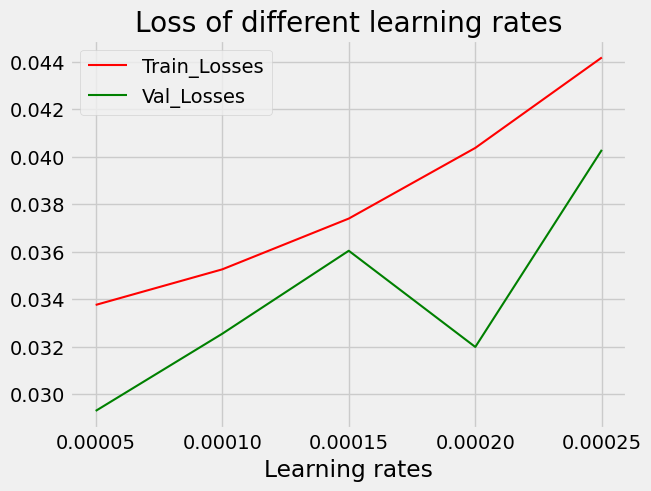

In [ ]:
plt.plot(
    learn_rates,
    final_train_losses_lr,
    label='Train_Losses',
    color='red',
    linewidth=1.5
)

plt.plot(
    learn_rates,
    final_val_losses_lr,
    label='Val_Losses',
    
    color='green', 
    linewidth=1.5
)

plt.xlabel('Learning rates')
plt.title('Loss of different learning rates')
plt.legend()
plt.xticks(learn_rates)
plt.savefig("output_image/loss_learning_rates_selection.jpg")
plt.show()

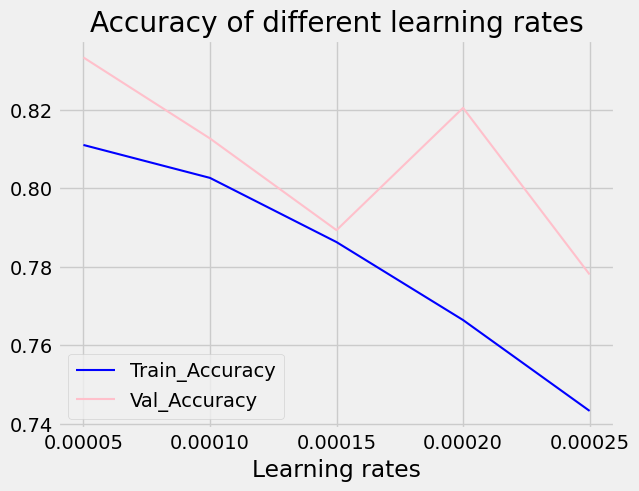

In [ ]:
plt.plot(
    learn_rates,
    final_train_accs_lr,
    label='Train_Accuracy',
    color='blue', 
    linewidth=1.5
)
plt.plot(
    learn_rates,
    final_val_accs_lr,
    label='Val_Accuracy', 
    color='pink', 
    linewidth=1.5
)
plt.xlabel('Learning rates')
plt.title('Accuracy of different learning rates')
plt.legend()
plt.xticks(learn_rates)
plt.savefig("output_image/accuracy_learning_rates_selection.jpg")
plt.show()

In [ ]:
batch_sizes=[8,16,32,64]
final_train_losses_bs= []
final_train_accs_bs = []
final_val_losses_bs = []
final_val_accs_bs = []
for batch_size in batch_sizes:
    saving_dir = f"batch_size{batch_size}_save_pretrained"
    print(f"batch size:{batch_size}")
    model = ViTForImageClassification.from_pretrained(model_name)
    model.classifier = nn.Linear(in_features=768, out_features=num_classes, bias=True)
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = train_model(model, train_dataset, val_dataset, LR, EPOCHS,BATCH_SIZE=batch_size)
    final_train_losses_bs.append(train_losses[-1])
    final_train_accs_bs.append(train_accs[-1])
    final_val_losses_bs.append(val_losses[-1])
    final_val_accs_bs.append(val_accs[-1])
    model.save_pretrained(saving_dir)

batch size:8


100%|██████████| 2354/2354 [13:34<00:00,  2.89it/s]


Epochs: 1 | Train Loss:  0.094             | Train Accuracy:  0.725             | Val Loss:  0.094             | Val Accuracy:  0.706
batch size:16


100%|██████████| 1177/1177 [13:11<00:00,  1.49it/s]


Epochs: 1 | Train Loss:  0.044             | Train Accuracy:  0.745             | Val Loss:  0.042             | Val Accuracy:  0.757
batch size:32


100%|██████████| 589/589 [13:19<00:00,  1.36s/it]


Epochs: 1 | Train Loss:  0.020             | Train Accuracy:  0.772             | Val Loss:  0.018             | Val Accuracy:  0.796
batch size:64


100%|██████████| 295/295 [13:12<00:00,  2.69s/it]


Epochs: 1 | Train Loss:  0.010             | Train Accuracy:  0.785             | Val Loss:  0.009             | Val Accuracy:  0.796


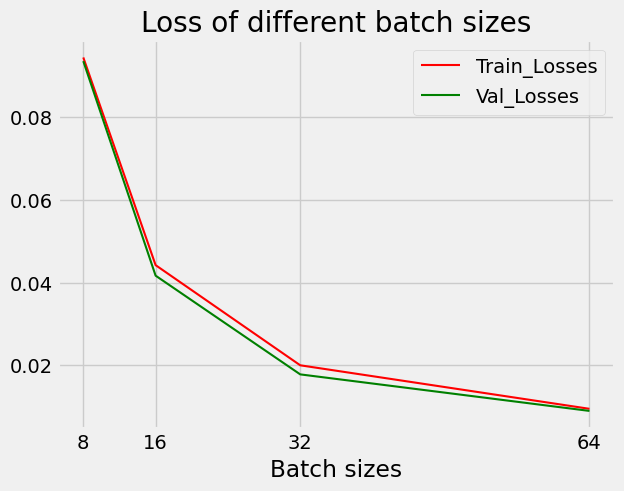

In [ ]:
plt.plot(
    batch_sizes,
    final_train_losses_bs,
    label='Train_Losses',
    color='red',
    linewidth=1.5
)

plt.plot(
    batch_sizes,
    final_val_losses_bs,
    label='Val_Losses', 
    
    color='green', 
    linewidth=1.5
)

plt.xlabel('Batch sizes')
plt.title('Loss of different batch sizes')
plt.legend()
plt.xticks(batch_sizes)
plt.savefig("output_image/loss_batch_sizes_selection.jpg")
plt.show()

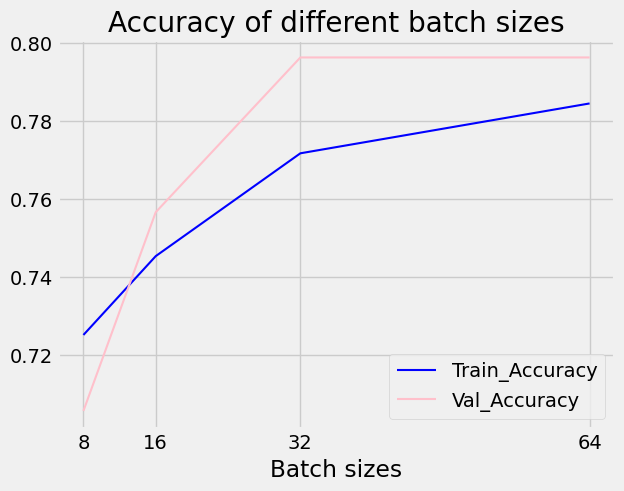

In [104]:
plt.plot(
    batch_sizes,
    final_train_accs_bs,
    label='Train_Accuracy',
    color='blue', 
    linewidth=1.5
)
plt.plot(
    batch_sizes,
    final_val_accs_bs,
    label='Val_Accuracy', 
    color='pink', 
    linewidth=1.5
)
plt.xlabel('Batch sizes')
plt.title('Accuracy of different batch sizes')
plt.legend()
plt.xticks(batch_sizes)
plt.savefig("output_image/accuracy_batch_sizes_selection.jpg")
plt.show()

In [82]:
attention_probs_dropout_probs=[0.05,0.1,0.15,0.2]
final_train_losses_apdp= []
final_train_accs_apdp = []
final_val_losses_apdp = []
final_val_accs_apdp = []
for atten_probs_dropout_prob in attention_probs_dropout_probs:
    # saving_dir = f"batch_size{batch_size}_save_pretrained"
    print(f"attention probabilities dropout ratio:{atten_probs_dropout_prob}")
    configuration = ViTConfig(attention_probs_dropout_prob =atten_probs_dropout_prob)
    model = ViTForImageClassification(configuration)
    model.classifier = nn.Linear(in_features=768, out_features=num_classes, bias=True)
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = train_model(model, train_dataset, val_dataset, lr, EPOCHS,BATCH_SIZE=16)
    final_train_losses_apdp.append(train_losses[-1])
    final_train_accs_apdp.append(train_accs[-1])
    final_val_losses_apdp.append(val_losses[-1])
    final_val_accs_apdp.append(val_accs[-1])
    # model.save_pretrained(saving_dir)


attention probabilities dropout ratio:0.05


100%|██████████| 1177/1177 [12:48<00:00,  1.53it/s]


Epochs: 1 | Train Loss:  0.076             | Train Accuracy:  0.612             | Val Loss:  0.075             | Val Accuracy:  0.611
attention probabilities dropout ratio:0.1


100%|██████████| 1177/1177 [13:19<00:00,  1.47it/s]


Epochs: 1 | Train Loss:  0.077             | Train Accuracy:  0.612             | Val Loss:  0.076             | Val Accuracy:  0.615
attention probabilities dropout ratio:0.15


100%|██████████| 1177/1177 [13:17<00:00,  1.48it/s]


Epochs: 1 | Train Loss:  0.075             | Train Accuracy:  0.613             | Val Loss:  0.074             | Val Accuracy:  0.616
attention probabilities dropout ratio:0.2


100%|██████████| 1177/1177 [13:23<00:00,  1.46it/s]


Epochs: 1 | Train Loss:  0.076             | Train Accuracy:  0.613             | Val Loss:  0.078             | Val Accuracy:  0.615


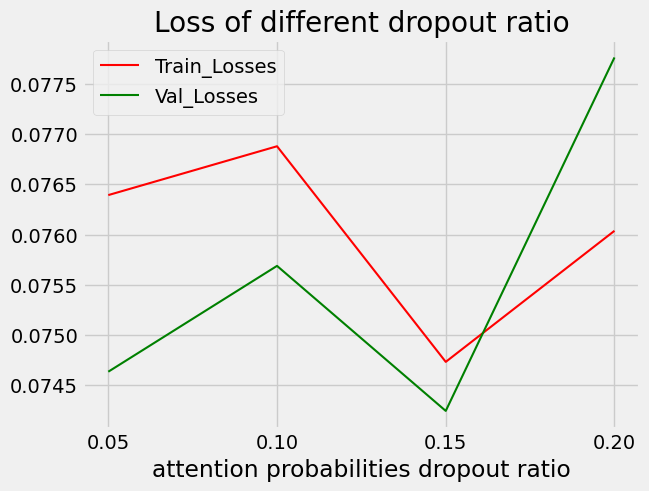

In [83]:
plt.plot(
    attention_probs_dropout_probs,
    final_train_losses_apdp,
    label='Train_Losses',
    color='red',
    linewidth=1.5
)

plt.plot(
    attention_probs_dropout_probs,
    final_val_losses_apdp,
    label='Val_Losses', 
    
    color='green', 
    linewidth=1.5
)

plt.xlabel('attention probabilities dropout ratio')
plt.title('Loss of different dropout ratio')
plt.legend()
plt.xticks(attention_probs_dropout_probs)
plt.savefig("output_image/loss_dropout_ratio_selection.jpg")
plt.show()

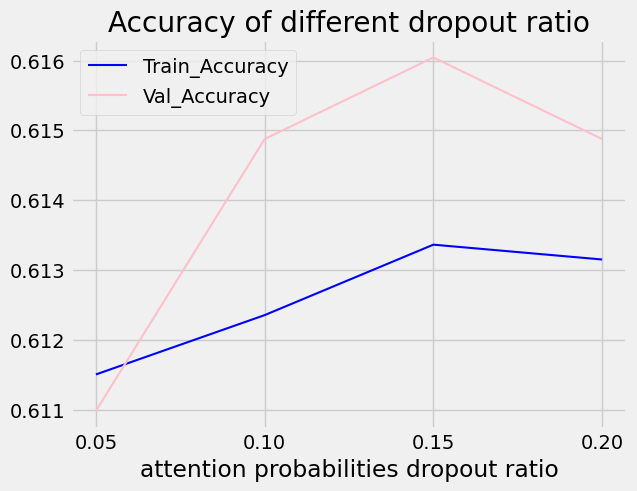

In [86]:
plt.plot(
    attention_probs_dropout_probs,
    final_train_accs_apdp,
    label='Train_Accuracy',
    color='blue', 
    linewidth=1.5
)
plt.plot(
    attention_probs_dropout_probs,
    final_val_accs_apdp,
    label='Val_Accuracy', 
    color='pink', 
    linewidth=1.5
)
plt.xlabel('attention probabilities dropout ratio')
plt.title('Accuracy of different dropout ratio')
plt.legend()
plt.xticks(attention_probs_dropout_probs)
plt.savefig("output_image/accuracy_dropout_ratio_selection.jpg")
plt.show()

In [89]:
layer_norm_eps =[1e-12,1e-10,1e-8,1e-6]
final_train_losses_lne= []
final_train_accs_lne = []
final_val_losses_lne = []
final_val_accs_lne = []
for layer_norm_ep  in layer_norm_eps :
    # saving_dir = f"batch_size{batch_size}_save_pretrained"
    print(f"Normalization layers epsilon:{layer_norm_ep}")
    configuration = ViTConfig(layer_norm_eps  =layer_norm_ep)
    model = ViTForImageClassification(configuration)
    model.classifier = nn.Linear(in_features=768, out_features=num_classes, bias=True)
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = train_model(model, train_dataset, val_dataset, lr, EPOCHS,BATCH_SIZE=16)
    final_train_losses_lne.append(train_losses[-1])
    final_train_accs_lne.append(train_accs[-1])
    final_val_losses_lne.append(val_losses[-1])
    final_val_accs_lne.append(val_accs[-1])
    # model.save_pretrained(saving_dir)


Normalization layers epsilon:1e-12


100%|██████████| 1177/1177 [13:05<00:00,  1.50it/s]


Epochs: 1 | Train Loss:  0.075             | Train Accuracy:  0.614             | Val Loss:  0.074             | Val Accuracy:  0.614
Normalization layers epsilon:1e-10


100%|██████████| 1177/1177 [13:09<00:00,  1.49it/s]


Epochs: 1 | Train Loss:  0.074             | Train Accuracy:  0.614             | Val Loss:  0.070             | Val Accuracy:  0.624
Normalization layers epsilon:1e-08


100%|██████████| 1177/1177 [12:59<00:00,  1.51it/s]


Epochs: 1 | Train Loss:  0.075             | Train Accuracy:  0.614             | Val Loss:  0.075             | Val Accuracy:  0.616
Normalization layers epsilon:1e-06


100%|██████████| 1177/1177 [13:07<00:00,  1.49it/s]


Epochs: 1 | Train Loss:  0.076             | Train Accuracy:  0.613             | Val Loss:  0.073             | Val Accuracy:  0.615


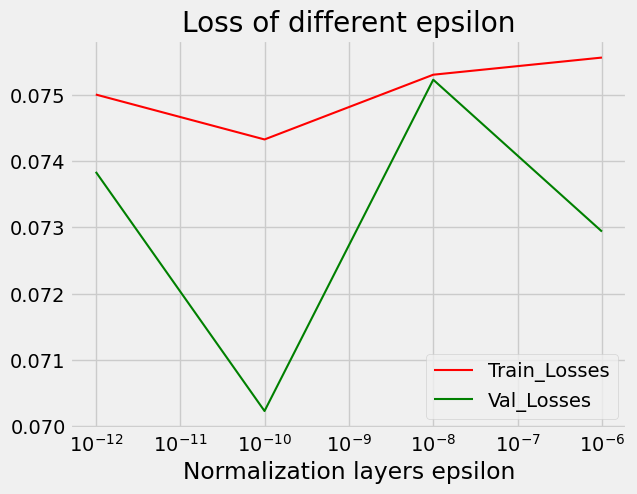

In [102]:
import matplotlib
plt.plot(
    layer_norm_eps,
    final_train_losses_lne,
    label='Train_Losses',
    color='red',
    linewidth=1.5
)

plt.plot(
    layer_norm_eps,
    final_val_losses_lne,
    label='Val_Losses', 
    
    color='green', 
    linewidth=1.5
)

plt.xlabel('Normalization layers epsilon')
plt.title('Loss of different epsilon')
plt.legend()
plt.xticks(layer_norm_eps)
plt.xscale("log")
plt.savefig("output_image/loss_epsilon_selection.jpg")
plt.show()

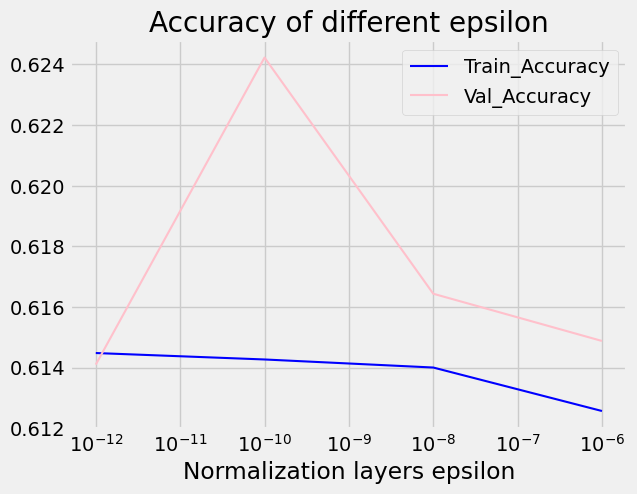

In [103]:
plt.plot(
    layer_norm_eps,
    final_train_accs_lne,
    label='Train_Accuracy',
    color='blue', 
    linewidth=1.5
)
plt.plot(
    layer_norm_eps,
    final_val_accs_lne,
    label='Val_Accuracy', 
    color='pink', 
    linewidth=1.5
)
plt.xlabel('Normalization layers epsilon')
plt.title('Accuracy of different epsilon')
plt.legend()
plt.xticks(layer_norm_eps)
plt.xscale("log")
plt.savefig("output_image/accuracy_epsilon_selection.jpg")
plt.show()

In [54]:
# plt.figure(figsize=(18, 6))

# plt.plot(
#     train_losses, 
#     label='Train_Losses', 
#     color='red', 
#     linewidth=1.5
# )
# plt.plot(
#     val_losses, 
#     label='Val_Losses', 
#     color='blue', 
#     linewidth=1.5
# )

# plt.plot(
#     train_accs, 
#     label='Train_Accuracy', 
#     color='green', 
#     linewidth=1.5
# )
# plt.plot(
#     val_accs, 
#     label='Val_Accuracy', 
#     color='pink', 
#     linewidth=1.5
# )

# plt.xlabel('Epoch')
# plt.ylabel('Loss / Accuracy')
# plt.title('Loss / Accuracy on train / validation')
# plt.legend()
# plt.show()

In [ ]:
# sub_df = pd.read_csv(BASE_PATH+'/sample_submission.csv')
# sub_df.head()

In [ ]:
# test_dataset = LeafDataset(df=sub_df, data_path=BASE_PATH, mode='test', transforms=transforms_val)

# def predict(model, test_dataset):
#     preds = []
#     test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)
    
#     for test_images, test_labels in tqdm(test_dataloader):
#         test_images = test_images.to(device)
#         test_labels = test_labels.to(device)

#         output = model(test_images)
#         _, predicted = torch.max(output.logits.data, 1)
#         preds.extend(predicted.cpu().data.numpy())
        
#     return preds    
# preds=predict(model, test_dataset)

In [ ]:
# sub_df['label'] = preds
# sub_df.to_csv('submission.csv', index=False)
# sub_df.head()

In [ ]:
# pt_model = ViTForImageClassification.from_pretrained(saving_dir,num_labels = num_classes)
# pt_model.to(device)

In [ ]:
# predict(pt_model, test_dataset)